# Baseline models

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

import scikitplot as skplt

import scikitplot as skplt

import xgboost as xgb

from utils.evaluation import evaluate_model
from utils.report import report_by_sections

In [2]:
train_data = pd.read_csv("data/train_data.csv", parse_dates=["block_time"])

In [3]:
features = [f for f in train_data.columns if f.endswith("_log_to_median_ratio")]

In [4]:
len(features)

53

In [5]:
model_train_data = train_data.loc[
    :, ["file_name", "transaction_id", "block_time"] + features + ["label"]
].fillna(0)

In [6]:
validation_data = pd.read_csv("data/validation_data.csv", parse_dates=["block_time"])

In [7]:
validation_model_data = validation_data.loc[
    :, ["file_name", "transaction_id", "block_time"] + features + ["label"]
].fillna(0)

## 1 Simple feature selection

In [8]:
from sklearn.feature_selection import mutual_info_classif

In [9]:
target_data = model_train_data.loc[model_train_data["label"] == 1, :]
ref_sample = model_train_data.loc[model_train_data["label"] == 0, :].sample(
    20000, random_state=1234
)
train_sample = pd.concat([ref_sample, target_data], axis=0).reset_index(drop=True)

In [10]:
mu_score = mutual_info_classif(
    train_sample.loc[:, features], train_sample["label"], random_state=1234
)

In [11]:
mu_score_df = pd.DataFrame(
    zip(features, mu_score), columns=["feature", "score"]
).sort_values("score", ascending=False)

In [12]:
# mu_score_df.to_csv("mu_score.csv", index=False)

In [13]:
mu_score_df.head(20)

,feature,score
20,snd_rcv_amt_usd_sum_tx_sum_log_to_median_ratio,0.156763
15,snd_rcv_amt_usd_sum_tx_min_log_to_median_ratio,0.150969
18,snd_rcv_amt_usd_sum_tx_mean_log_to_median_ratio,0.146914
17,snd_rcv_amt_usd_sum_tx_median_log_to_median_ratio,0.146618
16,snd_rcv_amt_usd_sum_tx_max_log_to_median_ratio,0.146384
39,snd_rcv_mean_time_diff_sec_tx_min_log_to_media...,0.136345
40,snd_rcv_mean_time_diff_sec_tx_max_log_to_media...,0.134952
41,snd_rcv_mean_time_diff_sec_tx_median_log_to_me...,0.134863
42,snd_rcv_mean_time_diff_sec_tx_mean_log_to_medi...,0.134172
33,snd_rcv_life_time_sec_tx_min_log_to_median_ratio,0.132944


In [14]:
train_sample.shape

(21671, 57)

In [15]:
selected = [
    "snd_rcv_amt_usd_sum_tx_sum_log_to_median_ratio",
    "snd_rcv_amt_usd_sum_tx_max_log_to_median_ratio",
    "snd_rcv_mean_time_diff_sec_tx_min_log_to_median_ratio",
    "snd_rcv_mean_time_diff_sec_tx_median_log_to_median_ratio",
    # "snd_rcv_life_time_sec_tx_min_log_to_median_ratio",
    "snd_rcv_life_time_sec_tx_median_log_to_median_ratio",
    "snd_rcv_tkn_type_cnt_tx_max_log_to_median_ratio"
    #'snd_rcv_tkn_type_cnt_tx_min_log_to_median_ratio',
    #'gas_limit_log_to_median_ratio',
    #'gas_price_log_to_median_ratio'
]

## 2 Model training and evaluation

In [16]:
X = model_train_data.loc[:, selected]
y = model_train_data["label"]
model = LogisticRegression(class_weight="balanced").fit(X, y)
# model = SVC(class_weight='balanced').fit(X, y)

In [17]:
train_pred_label = model.predict(model_train_data.loc[:, selected])
train_true_label = model_train_data["label"]

recall: 0.832, precision: 0.03, specificity: 0.913


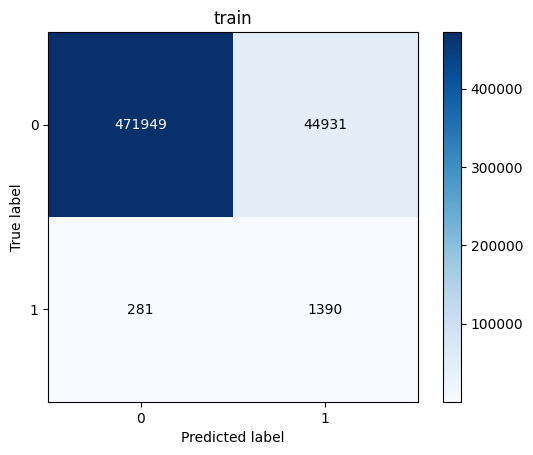

In [18]:
train_metrics = evaluate_model(
    train_true_label, train_pred_label, confusion_title="train"
)
print(
    f"recall: {train_metrics['recall']}, "
    + f"precision: {train_metrics['precision']}, "
    + f"specificity: {train_metrics['specificity']}"
)

In [19]:
val_pred_label = model.predict(validation_model_data.loc[:, selected])
val_true_label = validation_model_data["label"]

recall: 0.703, precision: 0.039, specificity: 0.966


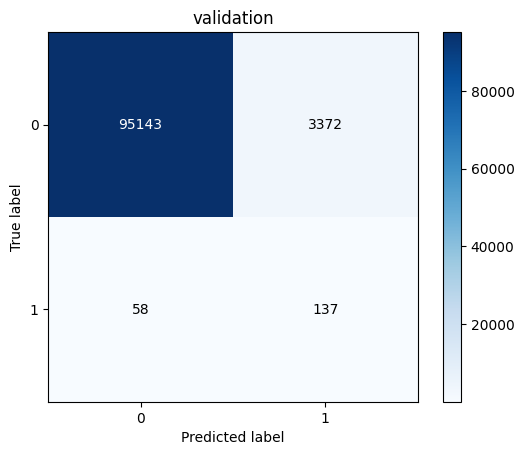

In [20]:
val_metrics = evaluate_model(
    val_true_label, val_pred_label, confusion_title="validation"
)
print(
    f"recall: {val_metrics['recall']}, "
    + f"precision: {val_metrics['precision']}, "
    + f"specificity: {val_metrics['specificity']}"
)

## 3 Report

In [21]:
if type(model) is LogisticRegression:
    model_coefs = (
        pd.DataFrame(zip(selected, model.coef_[0]), columns=["feature", "coef"])
        .sort_values("coef")
        .reset_index(drop=True)
    )
    print(model_coefs)

                                             feature      coef
0  snd_rcv_mean_time_diff_sec_tx_min_log_to_media... -0.356516
1    snd_rcv_tkn_type_cnt_tx_max_log_to_median_ratio -0.125351
2  snd_rcv_life_time_sec_tx_median_log_to_median_... -0.106081
3  snd_rcv_mean_time_diff_sec_tx_median_log_to_me... -0.102204
4     snd_rcv_amt_usd_sum_tx_sum_log_to_median_ratio  0.094479
5     snd_rcv_amt_usd_sum_tx_max_log_to_median_ratio  0.275353


In [22]:
if type(model) in {RandomForestClassifier, GradientBoostingClassifier}:
    feature_importance = pd.DataFrame(
        zip(selected, model.feature_importances_), columns=["feature", "importance"]
    )
    print(feature_importance)

In [23]:
train_results = model_train_data.loc[:, ["file_name", "label"]].copy()
train_results["pred_label"] = train_pred_label
train_results["exp_part"] = "train"

validation_results = validation_data.loc[:, ["file_name", "label"]]
validation_results["pred_label"] = val_pred_label
validation_results["exp_part"] = "validation"

model_results = pd.concat([train_results, validation_results])

In [24]:
cases = pd.read_csv("Validated_V0_Desriptions.csv").rename(
    {"File Names": "file_name", "Exploit Types": "exploit_type"}, axis=1
)
cases["file_name"] += ".csv"
cases = cases.loc[
    :, ["file_name", "exploit_type", "Minimum Time", "train/test splits", "Attack Link"]
]

model_results = model_results.merge(cases)

In [25]:
file_report, exploit_report = report_by_sections(model_results)

In [26]:
exploit_report

,exploit_type,exp_part,files,tp,fp,tn,fn,recall,precision
0,Access Control,train,54,1208,33232,357636,100,0.923547,0.035075
1,Access Control,validation,11,111,2235,57225,23,0.828358,0.047315
2,Flash Loan Attack,train,18,4,5654,54416,15,0.210526,0.000707
3,Flash Loan Attack,validation,5,16,513,25873,2,0.888889,0.030246
4,Phishing,train,16,1,390,8793,25,0.038462,0.002558
5,Phishing,validation,5,7,7,239,13,0.350000,0.500000
6,Price Manupilation,train,5,5,27,631,0,1.000000,0.156250
7,Price Manupilation,validation,1,1,1,595,0,1.000000,0.500000
8,Rug pull,train,25,172,5628,50473,141,0.549521,0.029655
9,Rug pull,validation,6,2,616,11211,20,0.090909,0.003236


In [27]:
file_report.groupby("exp_part")["catch_any"].mean()

exp_part
train         0.440678
validation    0.571429
Name: catch_any, dtype: float64